In [1]:
import numpy as np
import os
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array

2024-02-26 10:51:38.114359: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_dir = Path('dataset/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('dataset/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('dataset/valid')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [3]:
def image_processing(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [4]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [5]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 40000

Number of different labels: 40

Labels: ['waffles' 'chicken_curry' 'sushi' 'spring_rolls' 'churros'
 'lobster_roll_sandwich' 'french_toast' 'tacos' 'chicken_wings'
 'macaroni_and_cheese' 'pancakes' 'cup_cakes' 'bruschetta' 'hot_dog'
 'samosa' 'club_sandwich' 'steak' 'french_fries' 'ramen' 'pizza'
 'breakfast_burrito' 'fish_and_chips' 'oysters' 'cheesecake'
 'fried_calamari' 'creme_brulee' 'nachos' 'apple_pie' 'caesar_salad'
 'fried_rice' 'red_velvet_cake' 'lasagna' 'dumplings' 'hamburger'
 'lobster_bisque' 'spaghetti_carbonara' 'donuts' 'guacamole'
 'deviled_eggs' 'omelette']


In [6]:
train_df.head(5)

,Filepath,Label
0,dataset/train/waffles/3657399.jpg,waffles
1,dataset/train/chicken_curry/158711.jpg,chicken_curry
2,dataset/train/sushi/2458165.jpg,sushi
3,dataset/train/spring_rolls/2305540.jpg,spring_rolls
4,dataset/train/churros/244069.jpg,churros


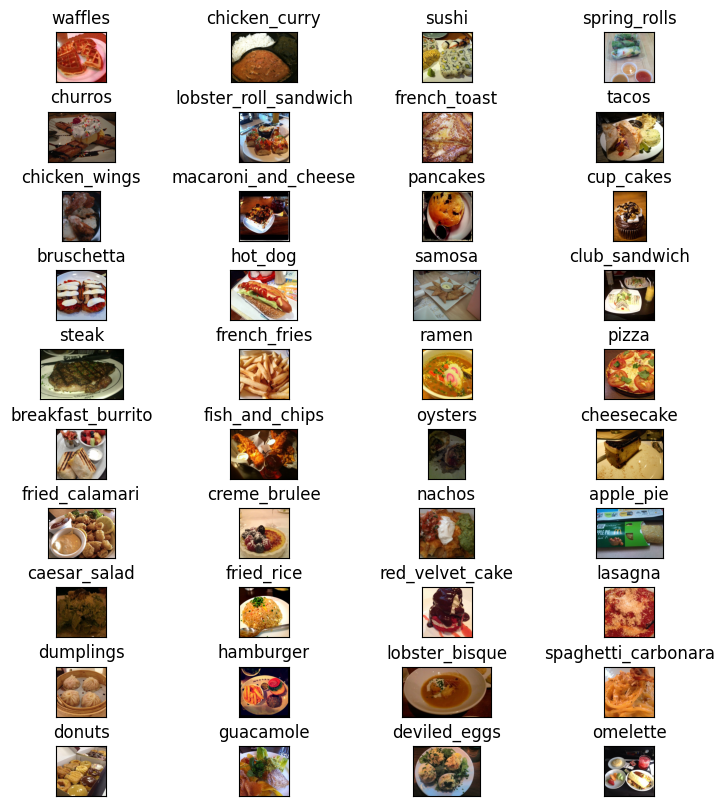

In [7]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [9]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 40000 validated image filenames belonging to 40 classes.


In [10]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 400 validated image filenames belonging to 40 classes.


In [11]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 400 validated image filenames belonging to 40 classes.


In [12]:
#Model creation
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [13]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(40, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10


2024-02-26 10:51:59.364232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - ETA: 0s - loss: 1.4146 - accuracy: 0.6100

2024-02-26 11:00:51.845719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 539s 429ms/step - loss: 1.4146 - accuracy: 0.6100 - val_loss: 1.0656 - val_accuracy: 0.7050
Epoch 2/10
1250/1250 [==============================] - 606s 484ms/step - loss: 1.0012 - accuracy: 0.7167 - val_loss: 0.8688 - val_accuracy: 0.7525
Epoch 3/10
1250/1250 [==============================] - 633s 506ms/step - loss: 0.8597 - accuracy: 0.7531 - val_loss: 0.7536 - val_accuracy: 0.7950
Epoch 4/10
1250/1250 [==============================] - 609s 487ms/step - loss: 0.7561 - accuracy: 0.7771 - val_loss: 0.6528 - val_accuracy: 0.8025
Epoch 5/10
1250/1250 [==============================] - 568s 454ms/step - loss: 0.6585 - accuracy: 0.8041 - val_loss: 0.4863 - val_accuracy: 0.8600
Epoch 6/10
1250/1250 [==============================] - 598s 478ms/step - loss: 0.5781 - accuracy: 0.8273 - val_loss: 0.4941 - val_accuracy: 0.8575
Epoch 7/10
1250/1250 [==============================] - 562s 450ms/step - loss: 0.5017 - accuracy: 0.8499 - val_loss: 0.451

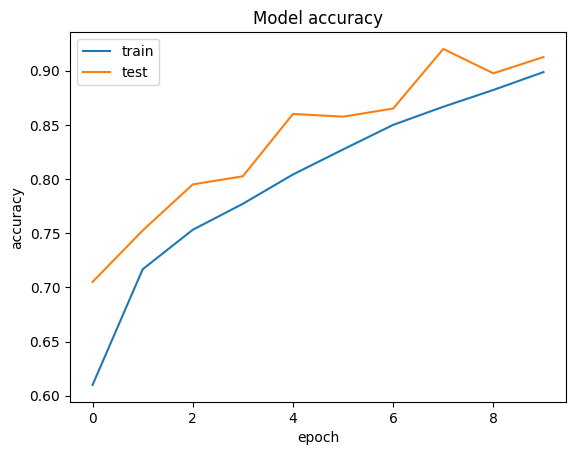

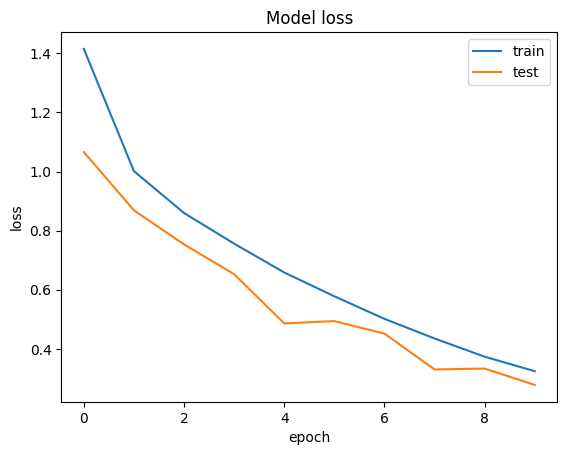

In [14]:
#View our training history graphically
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])

plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'])

plt.show()

In [17]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

2024-02-26 12:39:33.217963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


13/13 [==============================] - 6s 423ms/step


['spaghetti_carbonara',
 'cup_cakes',
 'churros',
 'fried_calamari',
 'fried_calamari',
 'red_velvet_cake',
 'chicken_curry',
 'steak',
 'chicken_wings',
 'creme_brulee',
 'hot_dog',
 'deviled_eggs',
 'bruschetta',
 'churros',
 'steak',
 'fish_and_chips',
 'lasagna',
 'omelette',
 'nachos',
 'chicken_curry',
 'breakfast_burrito',
 'sushi',
 'bruschetta',
 'creme_brulee',
 'oysters',
 'hamburger',
 'lobster_bisque',
 'guacamole',
 'club_sandwich',
 'spaghetti_carbonara',
 'chicken_wings',
 'chicken_curry',
 'creme_brulee',
 'pizza',
 'chicken_curry',
 'pancakes',
 'lasagna',
 'lobster_bisque',
 'caesar_salad',
 'apple_pie',
 'steak',
 'french_fries',
 'churros',
 'creme_brulee',
 'fish_and_chips',
 'steak',
 'hamburger',
 'bruschetta',
 'lobster_bisque',
 'samosa',
 'waffles',
 'cheesecake',
 'caesar_salad',
 'ramen',
 'donuts',
 'fried_rice',
 'guacamole',
 'pizza',
 'samosa',
 'hot_dog',
 'donuts',
 'fish_and_chips',
 'spaghetti_carbonara',
 'caesar_salad',
 'spring_rolls',
 'donuts',

In [18]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [20]:
img = output('dataset/test/fried_rice/554287.jpg')
img

1/1 [==============================] - 0s 85ms/step


'fried_rice'

In [21]:
model.save('Food_Classification_Model.h5')